# Example of how to do a mosaic from a continuous emission reconstruction

We do a sky reconstruction for different pointings of our HI test catalogs and then we coadd the pointings. For the reconstruction we assume a gaussian primary beam of around 1 degree FWHM.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u

from astropy.io import fits
from astropy.wcs import WCS
from astropy import coordinates as coords

from karabo.simulation.sky_model import SkyModel
from karabo.simulation.line_emission import freq_channels, karabo_reconstruction
from karabo.imaging.mosaic import mosaic_directories, mosaic_header, mosaic
from karabo.data.external_data import HISourcesSmallCatalogDownloadObject

from karabo.util.plotting_util import get_slices

%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


The observation location should be compatible with the MeerKAT site. Also, the observation time and the coordinate has to be set. We need to pay attention that the sky model passes through the field of view during the observation!

In [2]:
# Specify an observation time
t_obs = "2000-03-20 12:06:39"
t_len = "03:05:00.000"
observing_time = Time(t_obs)

Parameter definitions.

In [3]:
# Parameters needed for our sky reconstruction
survey = HISourcesSmallCatalogDownloadObject()
catalog_path = survey.get()
outer_rad = 5.0  # We define the FOV size with an outer radius, the center of the radius is phase-center

# These are the parameters defining the mosaic we want to make and the pointings
location = "20.0 -30.0"  # This is the phase center used for the mosaic
phase_center = (
    20.0,
    -30.0,
) * u.deg  # This is the phase center of the telescope used for getting the sky
size = (
    5.0 * u.deg
)  # This is the side length of the square in degrees our mosaic will be in

# Parameters for the plots
vmax = 0.4
vmax_i = 0.1
vmax_rec = 0.2

We create the sky

In [4]:
# %%timeit

sky_pointing = SkyModel.get_sky_model_from_h5_to_xarray(catalog_path)

sky_pointing = sky_pointing.filter_by_radius_euclidean_flat_approximation(
    inner_radius_deg=0,
    outer_radius_deg=outer_rad,
    ra0_deg=phase_center[0].value,
    dec0_deg=phase_center[1].value,
)

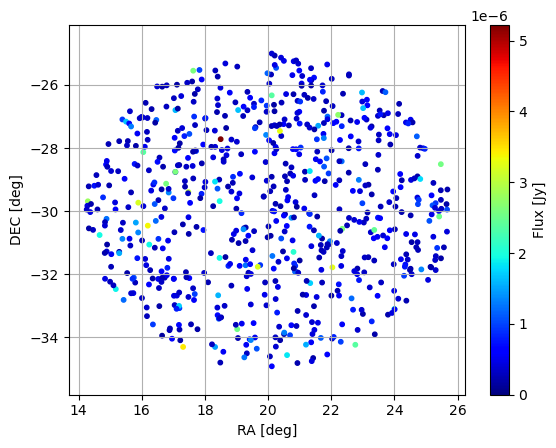

In [5]:
sky_pointing.explore_sky(
    phase_center=phase_center.value,
    vmin=0,
    s=10,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
)

In [6]:
# Load sky into memory and close connection to h5
sky_pointing.compute()

Frequency/Redshift channels

In [7]:
redshift_channel, freq_channel, freq_bin, freq_mid = freq_channels(
    sky_pointing.sources[:, 13], 1
)
print(freq_bin)

The frequency channel starts at: 806975898.0275512 Hz
The bin sizes of the freq channel are: [1.03836541e+08] Hz
[1.03836541e+08]


We use the MeerKAT telescope in our simulation. You can find more information about the FWHM of the beam here: https://skaafrica.atlassian.net/servicedesk/customer/portal/1/article/277315585

In [8]:
FWHM_ref = (
    1 * u.deg
)  # reference FWHM of the simulated gaussian primary beam (FWHM at 1.5GHz)

FWHM_real = np.sqrt(89.5 * 86.2) / 60.0 * (1e3 / (freq_mid / 10**6)) * u.deg
print("The FWHM of the Gaussian primary beam at the mid frequency is: ", FWHM_real)
fac = 0.87  # This is the ideal position if the primary beam is gaussian
offset = (
    FWHM_real * fac
)  # Radial distance between central pointing and the other pointings

img_size = 1024  # Pixel size of the pointing
size_pntg = 1.2 * FWHM_real  # Size of the pointing in degrees

# Position of the pointings
center1 = coords.SkyCoord(ra=phase_center[0], dec=phase_center[1], frame="icrs")
center2 = coords.SkyCoord(
    ra=phase_center[0] + offset, dec=phase_center[1], frame="icrs"
)
pointings = [center1, center2]

print(pointings)

print(pointings[1].ra.deg)

The FWHM of the Gaussian primary beam at the mid frequency is:  1.938803526858092 deg
[<SkyCoord (ICRS): (ra, dec) in deg
    (20., -30.)>, <SkyCoord (ICRS): (ra, dec) in deg
    (21.68675907, -30.)>]
21.68675906836654


In [10]:
workdir = "results/Mosaic_test_2"
mosaic_directories(workdir, overwrite=True)

We do a sky reconstruction for every redshift bin for every pointing and save it in the corresponding folders.

Reconstruction of pointing 0...
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_23a39e20-4aa6-4a4f-a687-06697c10955b directory for data object storage.
Saved visibility to results/Mosaic_test_2/unused_output/pointing0.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_a25d59a3-6532-4747-b0a2-5001d7132310 directory for data object storage.
Reconstruction of pointing 1...
Creating /scratch/snx3000/lmachado/karabo_folder/interferometer_sim_fhdir_1522d3b1-aa98-455f-92bb-58df8a5e73d4 directory for data object storage.
Saved visibility to results/Mosaic_test_2/unused_output/pointing1.vis
Creating /scratch/snx3000/lmachado/karabo_folder/imager_fhdir_52f02705-7f8c-4fad-bd0b-1f561c3aa5bf directory for data object storage.


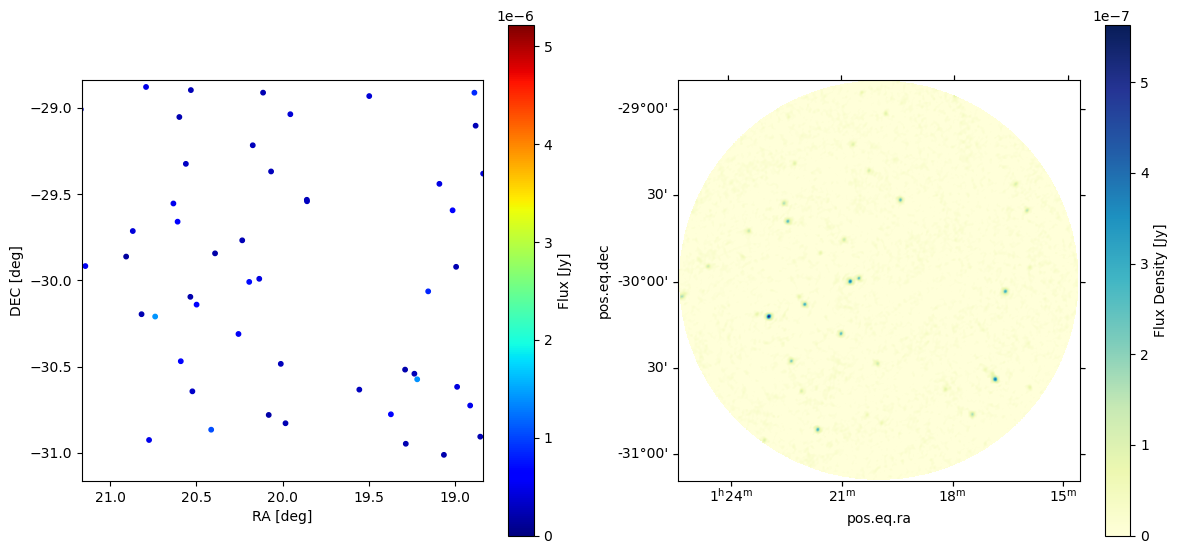

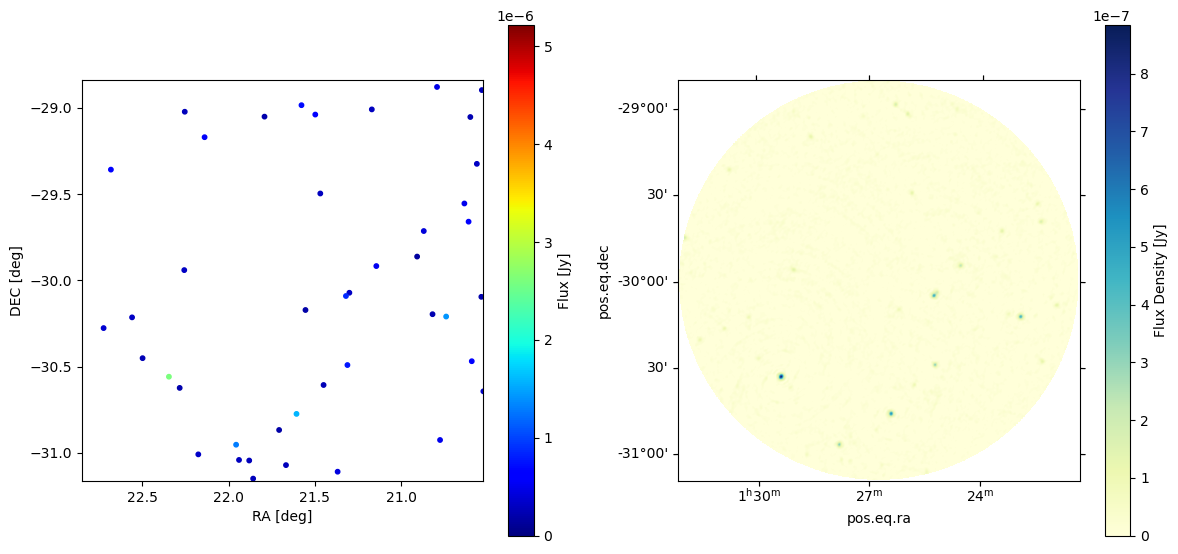

In [11]:
outfile = workdir + "/unused_output/pointing"

for k in range(len(pointings)):
    print("Reconstruction of pointing " + str(k) + "...")

    image, header = karabo_reconstruction(
        outfile=outfile + str(k),
        mosaic_pntg_file=workdir + "/raw/pointing" + str(k),
        sky=sky_pointing,
        ra_deg=pointings[k].ra.deg,
        dec_deg=pointings[k].dec.deg,
        img_size=img_size,
        start_freq=freq_mid,
        freq_bin=freq_bin[0],
        beam_type="Gaussian beam",
        cut=size_pntg.value,
        channel_num=1,
        pdf_plot=True,
        circle=True,
    )

Now let us start with the actual mosaicing, for every redshfit bin. We first need to create the FITS header for the mosaic, which is the same in every redshift channel. Then we additionally create a file for every channel which contains the metadata of the pointings in this channel. With these two files we create the reprojections which we then use to coadd the pointings.
We take the resolution to be 5 in order for the simulation does not take to long. 

In [12]:
mosaic_header(
    output_directory_path=workdir,
    location=location,
    width=size.value,
    resolution=5.0,
    sin_projection=True,
)

mHdr:             {'status': '0', 'count': 16}


In [13]:
mosaic(output_directory_path=workdir)

mImgtbl (raw):    {'status': '0', 'count': 2, 'badfits': 0, 'badwcs': 0}
mProjExec:           {'status': '0', 'count': 2, 'failed': 0, 'nooverlap': 0}
mImgtbl (projected): {'status': '0', 'count': 2, 'failed': 0, 'nooverlap': 0}
mAdd:                {'status': '0', 'time': 4.0}


# Plot Scatterplot onto Reconstruction

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 20.0  -30.0  
CRPIX : 1801.0  1800.5  
NAXIS : 3601  3600


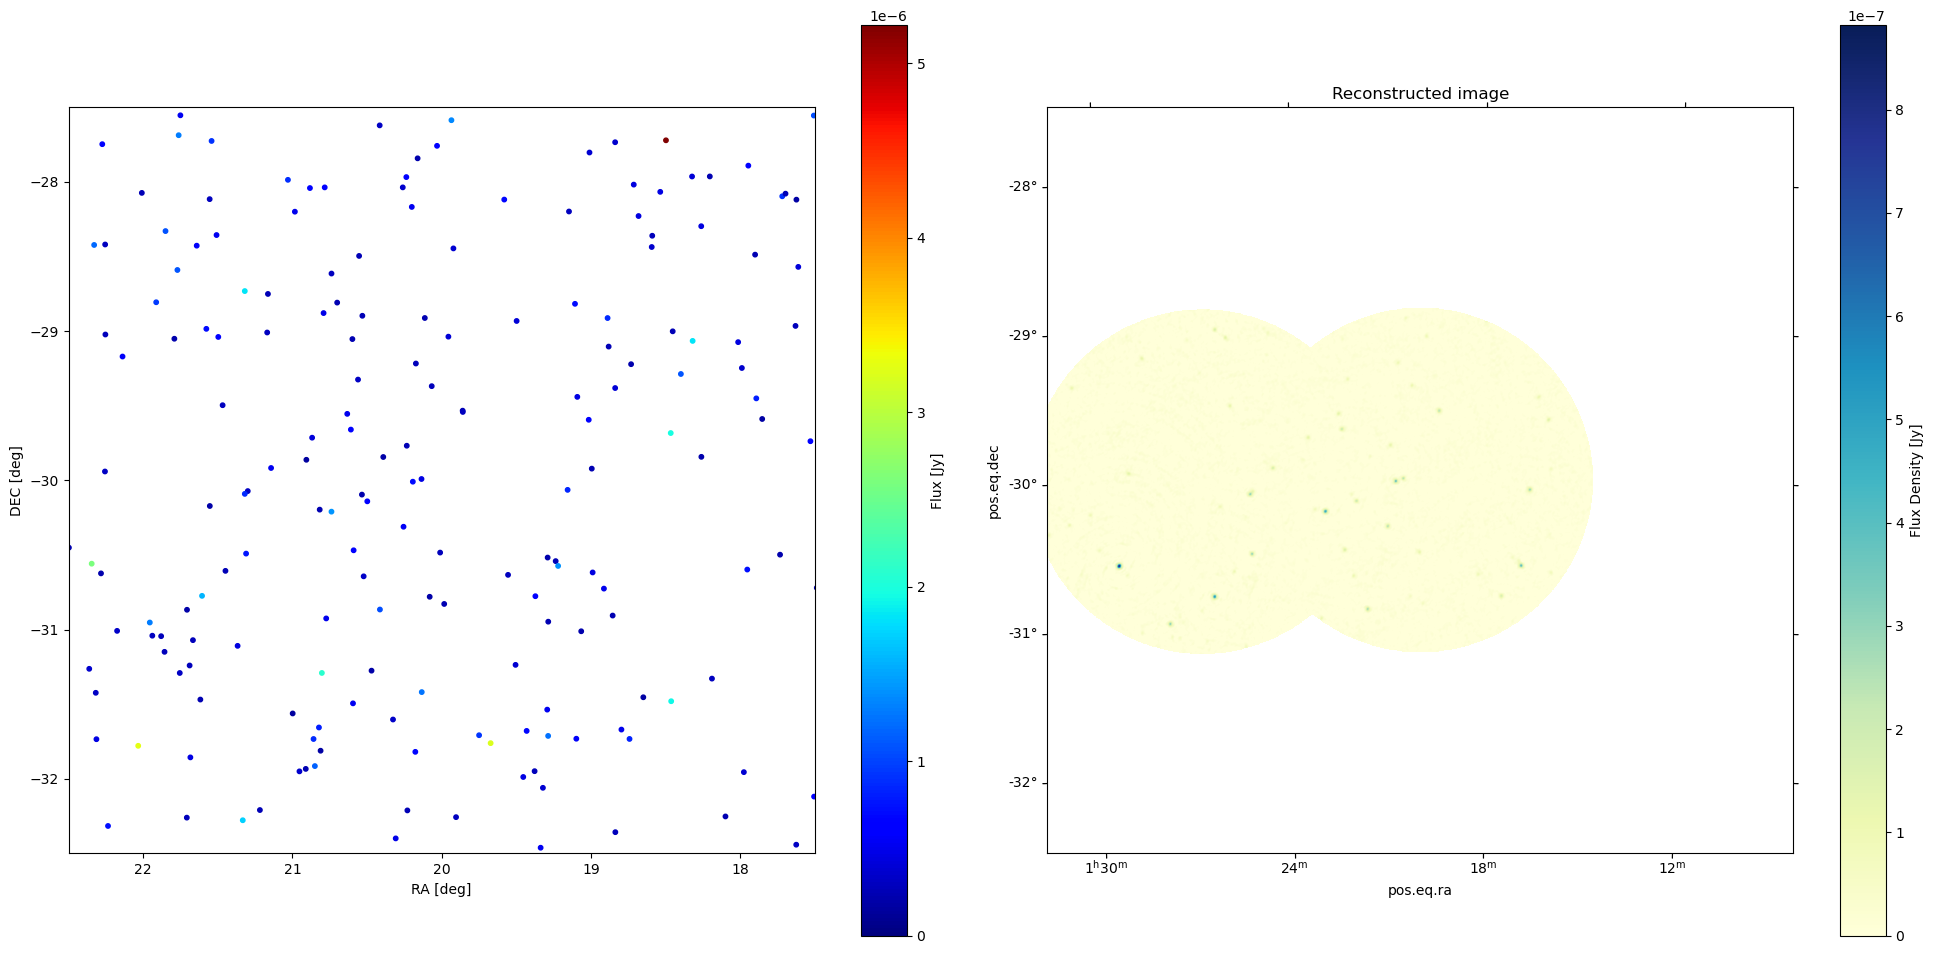

In [14]:
dirty_image, header = fits.getdata(
    workdir + "/mosaic_uncorrected.fits", ext=0, header=True
)

wcs = WCS(header)
print(wcs)

slices = get_slices(wcs)

plt.figure(figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
scatter = ax1.scatter(
    sky_pointing[:, 0],
    sky_pointing[:, 1],
    c=sky_pointing[:, 2],
    vmin=0,
    s=10,
    cmap="jet",
)
ax1.set_aspect("equal")
plt.colorbar(scatter, ax=ax1, label="Flux [Jy]")
ax1.set_xlim(
    (phase_center[0].value - size.value / 2, phase_center[0].value + size.value / 2)
)
ax1.set_ylim(
    (phase_center[1].value - size.value / 2, phase_center[1].value + size.value / 2)
)
ax1.set_xlabel("RA [deg]")
ax1.set_ylabel("DEC [deg]")
ax1.invert_xaxis()

ax2 = plt.subplot(122, projection=wcs, slices=slices)
recon_img = ax2.imshow(dirty_image, cmap="YlGnBu", origin="lower", vmin=0)
plt.colorbar(recon_img, ax=ax2, label="Flux Density [Jy]")

plt.title("Reconstructed image")
plt.tight_layout()
plt.savefig(workdir + "/Mosaic.pdf")
plt.show()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 20.0  -30.0  
CRPIX : 1801.0  1800.5  
NAXIS : 3601  3600


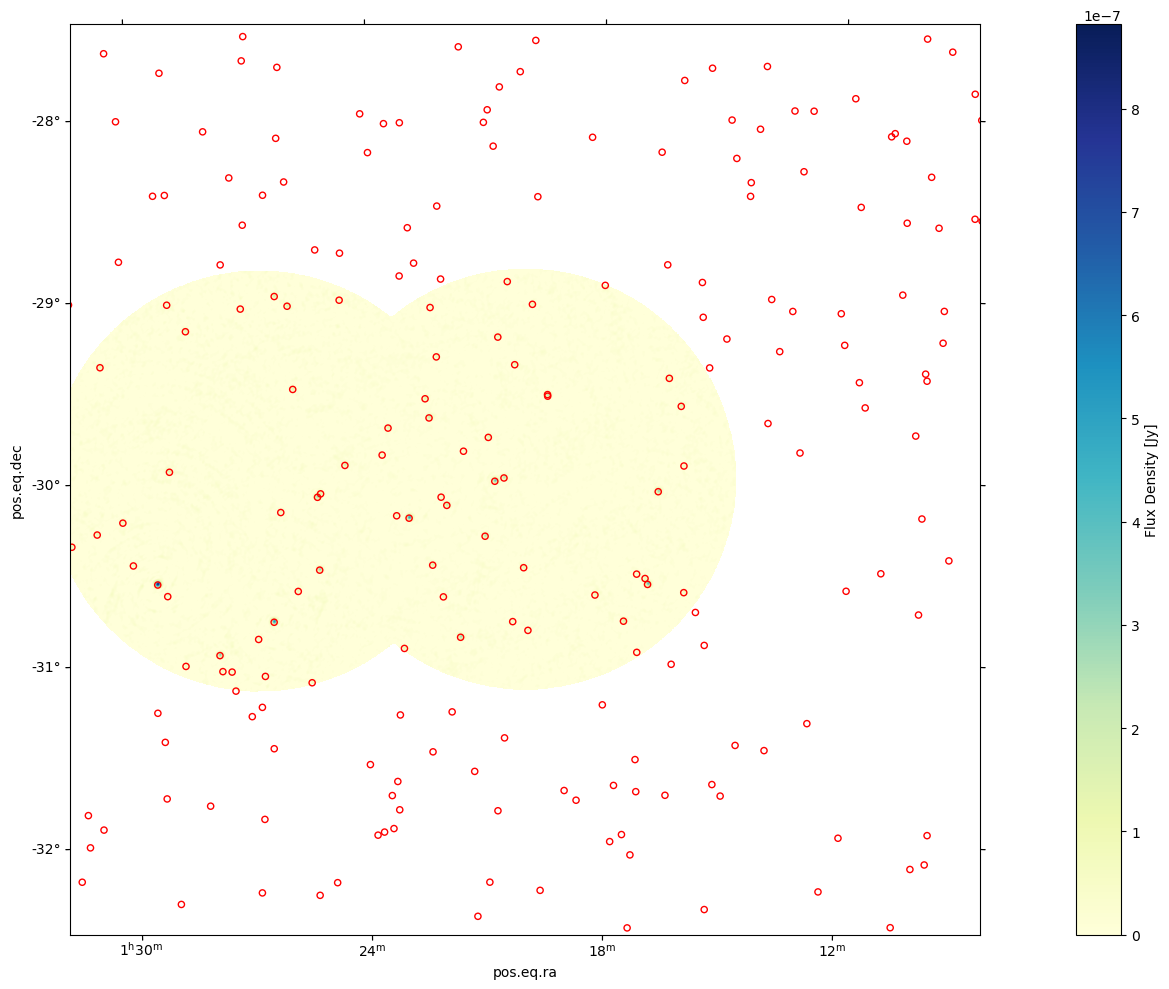

In [15]:
# from matplotlib.colors import LogNorm
dirty_image, header = fits.getdata(
    workdir + "/mosaic_uncorrected.fits", ext=0, header=True
)

wcs = WCS(header)
slices = get_slices(wcs)
print(wcs)

# We need to transform the sky_pointing to the same pixel values as the dirty_image
px, py = wcs.wcs_world2pix(sky_pointing[:, 0], sky_pointing[:, 1], 0)

# Create the figure and axes
plt.figure(figsize=(20, 10))

ax = plt.subplot(111, projection=wcs, slices=slices)

# Plot the image using imshow
recon_img = ax.imshow(dirty_image, cmap="YlGnBu", origin="lower", vmin=0)
# recon_img = ax.imshow(dirty_image, cmap='YlGnBu', origin='lower', norm=LogNorm(vmin=0.01, vmax=vmax_rec))

# Plot the scatterplot using scatter
ax.scatter(px, py, facecolors="none", edgecolors="r", s=20)

plt.colorbar(recon_img, ax=ax, label="Flux Density [Jy]")
ax.set_xlim((0, dirty_image.shape[0]))
ax.set_ylim((0, dirty_image.shape[1]))

# Show the plot
plt.tight_layout()
plt.savefig(workdir + "/Mosaic_overlayed.pdf")
plt.show()